In [ ]:
"""

Disclaimer!

Every value genereted by this model is not representative of any process within Royal Dutch Shell.
Proper usage requires statistical analysis of the representative data prior to custom data generation.

Use at your own discretion!

"""

'\n\nDisclaimer!\n\nEvery value genereted by this model is not representative of any process within Royal Dutch Shell.\nProper usage requires statistical analysis of the representative data prior to custom data generation.\n\nUse at your own discretion!\n\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Synthetic Data Generator Interface
@Version: 1.0.pre-alpha

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Necessary Imports

In [ ]:
import os 
os.chdir('/content/drive/My Drive/Shell/Unzipped files/')

from util import gen_regression_symbolic #custom lib
import random
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# MICE
!pip3 install impyute
from impyute.imputation.cs import mice
import sklearn.metrics as metrics

# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
from IPython.display import clear_output
clear_output()
%matplotlib inline

In [ ]:
# SET  Statistical Parameters
co2_mean = 96.8
methane_mean = 2.85*(10**-3)
nitrous_oxide_mean = 5.7*(10**-4)

# Pre-processing and Multiple Imputation by Chained Reactions

In [ ]:
def corr(data) :
    corr = data.corr()
    return corr.style.background_gradient().set_precision(2)
def create_nan_df(df, dist_nan_columns = [0.20, 0.15, 0.08, 0],random_seed = 1):
  nan_df = df.copy()
  random.seed(a=random_seed, version=2)
  nan_percent = {'CO2':dist_nan_columns[0], 'CH4':dist_nan_columns[1], 'N2O':dist_nan_columns[2], 'Estimated_other_CO2e':dist_nan_columns[3] }
  for col in nan_percent:
      for i, row_value in nan_df[col].iteritems():
          if random.random() <= nan_percent[col]:
              nan_df.loc[i,col] = np.nan
  return nan_df


def store_nan_index(nan_df, column_limit = 3): 
  d_indexes = {}
  for key in nan_df.columns[:column_limit]:
    d_indexes[key] = list(nan_df[key].index[nan_df[key].apply(np.isnan)])
  return d_indexes
  # store indexes nan per column
#d = store_nan_index(nan_df, 3) # MAYBE NOT NECESSARY

#Imputed estimation 1
def replace_with_imputes_1 (nan_df, column_limit = 4, co2_mean = co2_mean, methane_mean = methane_mean, nitrous_oxide_mean = nitrous_oxide_mean):  # always 4, includes estimated_other.
  clone = nan_df.drop(nan_df.columns[column_limit:], axis=1)

  #AVERAGE method
  nan_df['CO2'].fillna(co2_mean, inplace = True)
  nan_df['CH4'].fillna(methane_mean, inplace = True)
  nan_df['N2O'].fillna(nitrous_oxide_mean, inplace = True)

  for i in range(len(nan_df)):
    nan_df.loc[i,'Average_estimation_CO2e'] = nan_df ['CO2'][i] + 25* nan_df ['CH4'][i] + 298* nan_df ['N2O'][i]
  # MICE
  imputed = mice(clone.values)

                                                                                 #nan_df.loc[:,:3] = imputed
  for i in range(len(nan_df)):
    nan_df.loc[i,'MICE_estimation_CO2e'] = imputed [i][0] + 25* imputed[i][1] + 298* imputed[i][2]
  del(clone)
 
  # make error metrics in respond to average and in respond to MICE
  metrics_df = pd.DataFrame(columns = ['MAE','RMSE'], index = ['True-Value_vs_Process-Average','True-Value_vs_Average-estimation','True-Value_vs_MICE-estimation'])
  ## true-vs-avg
  mae_1 = metrics.mean_absolute_error(nan_df['True-Value_CO2e'], nan_df['Process-Average_CO2e']).round(4)
  mse_1 = metrics.mean_squared_error(nan_df['True-Value_CO2e'], nan_df['Process-Average_CO2e']).round(4)
  rmse_1 = np.sqrt(mse_1) 
  ## 
  mae_0 = metrics.mean_absolute_error(nan_df['True-Value_CO2e'], nan_df['Average_estimation_CO2e']).round(4)
  mse_0 = metrics.mean_squared_error(nan_df['True-Value_CO2e'], nan_df['Average_estimation_CO2e']).round(4)
  rmse_0 = np.sqrt(mse_0) 
  ## true-vs-MICE
  mae_2 = metrics.mean_absolute_error(nan_df['True-Value_CO2e'], nan_df['MICE_estimation_CO2e']).round(4)
  mse_2 = metrics.mean_squared_error(nan_df['True-Value_CO2e'], nan_df['MICE_estimation_CO2e']).round(4)
  rmse_2 = np.sqrt(mse_2) 
  metrics_df.loc[:,'MAE'] = [mae_1,mae_0,mae_2]
  metrics_df.loc[:,'RMSE'] = [rmse_1,rmse_0,rmse_2]
  return nan_df, metrics_df

# nan_df[nan_df.isna().any(axis=1)]
# Imputed estimation 2




def list_metrics_to_excel (l):
  for i, df in enumerate(l): 
    df.to_excel("metric_tables.xlsx",
             sheet_name= 'metrics_df-' + str(i))   
## PLOTS
def plot_nan_df(nan_df, figs = (11.7, 8.27)) :
  #plt.style.use('fast')
  plt.style.use('seaborn-poster')
  #plt.style.use('ggplot')

  #sns.set(rc={'figure.figsize':(10.7,7.27)}) # changes while background

  plt.figure(figsize=figs)

  sns.distplot(nan_df.loc[:,'Average_estimation_CO2e'], hist=False, label = 'MEAN estimate', color = 'orange')
  sns.distplot(nan_df.loc[:,'True-Value_CO2e'], hist=False, label = 'True distribution process', color = 'red')
  sns.distplot(nan_df.loc[:,'Estimated_other_CO2e'], hist=False, label = 'Estimated distribution other process', color= 'green')
  sns.distplot(nan_df.loc[:,'MICE_estimation_CO2e'], hist=False, label = 'MICE', color = 'blue')

  plt.ylabel('Density')
  plt.xlabel('Mean Imputation Distribution Check')
  plt.title("Distribution Comparison")
  plt.tight_layout() 
  plt.show()

In [ ]:
corr(df)

,CO2,CH4,N2O,Estimated_other_CO2e,True-Value_CO2e,Process-Average_CO2e
CO2,1.00,0.05,0.03,0.45,1.00,0.00
CH4,0.05,1.00,-0.03,0.01,0.05,-0.00
N2O,0.03,-0.03,1.00,0.06,0.03,-0.00
Estimated_other_CO2e,0.45,0.01,0.06,1.00,0.45,0.00
True-Value_CO2e,1.00,0.05,0.03,0.45,1.00,-0.00
Process-Average_CO2e,0.00,-0.00,-0.00,0.00,-0.00,1.00


In [ ]:
#nan_df.head()
nan_df.describe()

,CO2,CH4,N2O,Estimated_other_CO2e,True-Value_CO2e,Process-Average_CO2e,Average_estimation_CO2e,MICE_estimation_CO2e
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000
mean,96.823185,0.002849,0.000568,108.749759,97.031482,9.704111e+01,97.063800,97.013566
std,4.394210,0.000132,0.000027,9.887772,4.814689,9.526037e-13,4.394384,4.479511
min,73.491692,0.002374,0.000458,84.258064,73.735887,9.704111e+01,73.735887,73.735887
25%,94.202147,0.002768,0.000552,101.895842,93.758943,9.704111e+01,94.442238,94.257294
50%,96.800000,0.002850,0.000570,107.063783,96.857103,9.704111e+01,97.038321,96.792366
75%,99.298123,0.002924,0.000585,114.560518,100.245380,9.704111e+01,99.546296,99.753440
max,116.275907,0.003377,0.000664,145.777391,116.525558,9.704111e+01,116.526130,116.527407


## CASES

In [ ]:
# 0 normal std bias 15. 10 000

df = pd.read_csv("mock_10000_noise_15.csv")
nan_df = create_nan_df(df, dist_nan_columns = [0.20, 0.15, 0.08, 0],random_seed = 1)
imputed_df, metrics_df = replace_with_imputes_1 (nan_df, column_limit = 4) 
metrics_df

,MAE,RMSE
True-Value_vs_Process-Average,3.8075,4.780418
True-Value_vs_Average-estimation,0.7828,2.143152
True-Value_vs_MICE-estimation,0.6959,1.918098


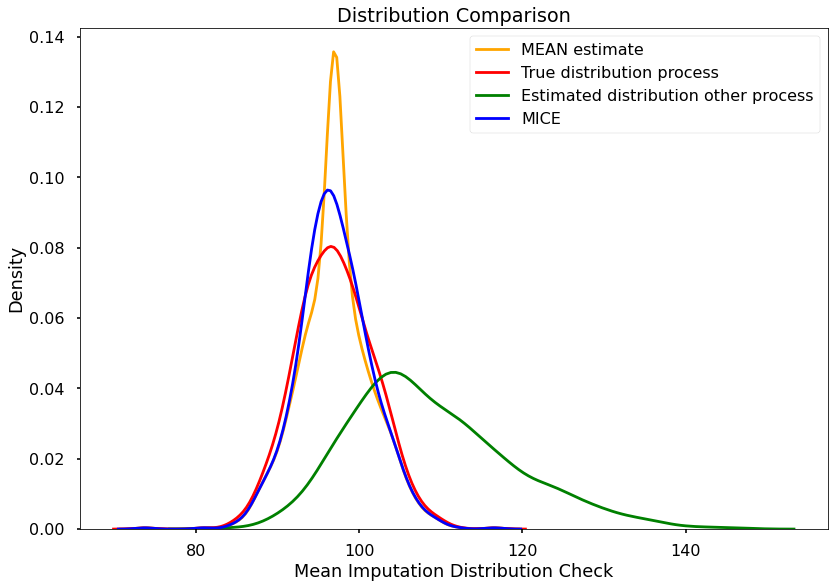

                                     MAE      RMSE
True-Value_vs_Process-Average     3.8269  4.812286
True-Value_vs_Average-estimation  0.6692  1.965706
True-Value_vs_MICE-estimation     0.6083  1.750457


In [ ]:
# 1.1 normal std bias 15.

df = pd.read_csv("mock_1000_noise_15.csv")
nan_df = create_nan_df(df, dist_nan_columns = [0.20, 0.15, 0.08, 0],random_seed = 1)
imputed_df, metrics_df = replace_with_imputes_1 (nan_df, column_limit = 4) 
plot_nan_df(imputed_df) #, figs = (8,5)
print(metrics_df)

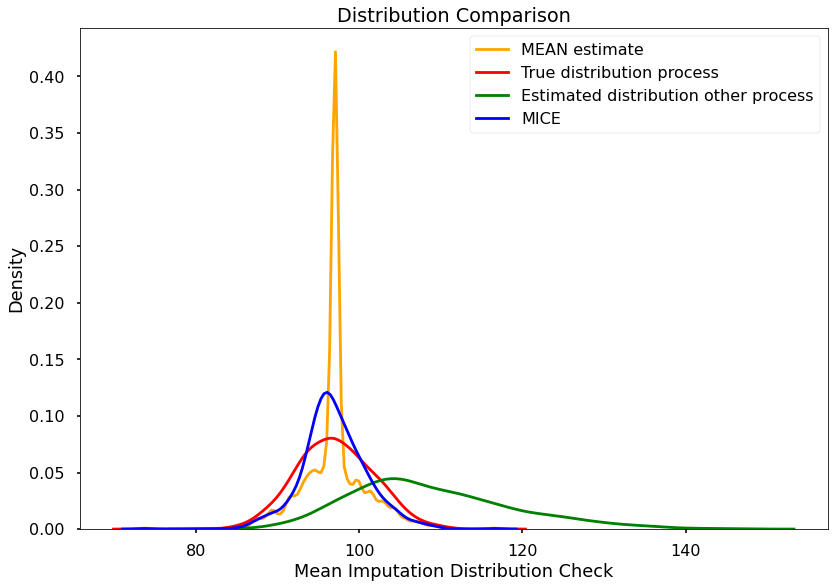

,MAE,RMSE
True-Value_vs_Process-Average,3.8269,4.812286
True-Value_vs_Average-estimation,1.4799,2.975685
True-Value_vs_MICE-estimation,1.3312,2.664714


In [ ]:
# 1.2 normal std bias 15. CHANGE IN MISSING DATA

df = pd.read_csv("mock_1000_noise_15.csv")
nan_df = create_nan_df(df, dist_nan_columns = [0.4, 0.3, 0.2, 0],random_seed = 1) # CH4 and N2O dont make much of a difference
imputed_df, metrics_df = replace_with_imputes_1 (nan_df, column_limit = 4) 
plot_nan_df(imputed_df) 
metrics_df

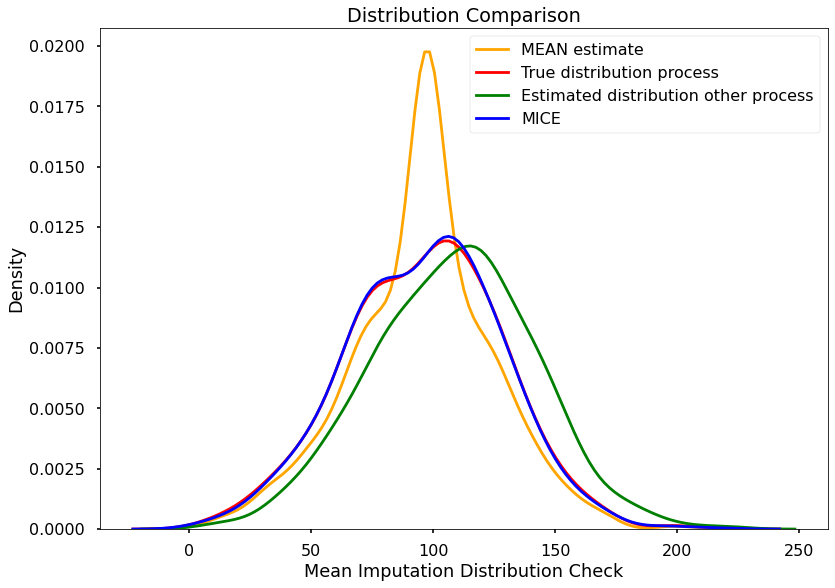

,MAE,RMSE
True-Value_vs_Process-Average,25.8289,32.171111
True-Value_vs_Average-estimation,4.6605,13.712750
True-Value_vs_MICE-estimation,1.3181,3.957866


In [ ]:
#1.3 33% std bias 15 
df = pd.read_csv("mock_1000_noise_third.csv")
nan_df = create_nan_df(df, dist_nan_columns = [0.20, 0.15, 0.08, 0],random_seed = 1)
imputed_df, metrics_df = replace_with_imputes_1 (nan_df, column_limit = 4) 
plot_nan_df(imputed_df) 
metrics_df

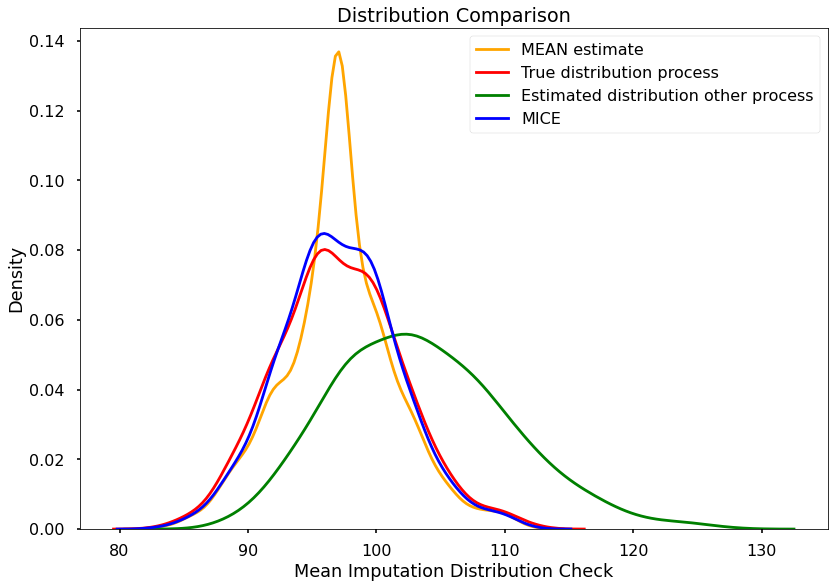

,MAE,RMSE
True-Value_vs_Process-Average,3.8745,4.843398
True-Value_vs_Average-estimation,0.7187,2.121438
True-Value_vs_MICE-estimation,0.5228,1.560577


In [ ]:
# 2.1 normal std bias 8
df = pd.read_csv("mock_1000_noise_8.csv")
nan_df = create_nan_df(df, dist_nan_columns = [0.20, 0.15, 0.08, 0],random_seed = 1)
imputed_df, metrics_df = replace_with_imputes_1 (nan_df, column_limit = 4) 
plot_nan_df(imputed_df) 
metrics_df

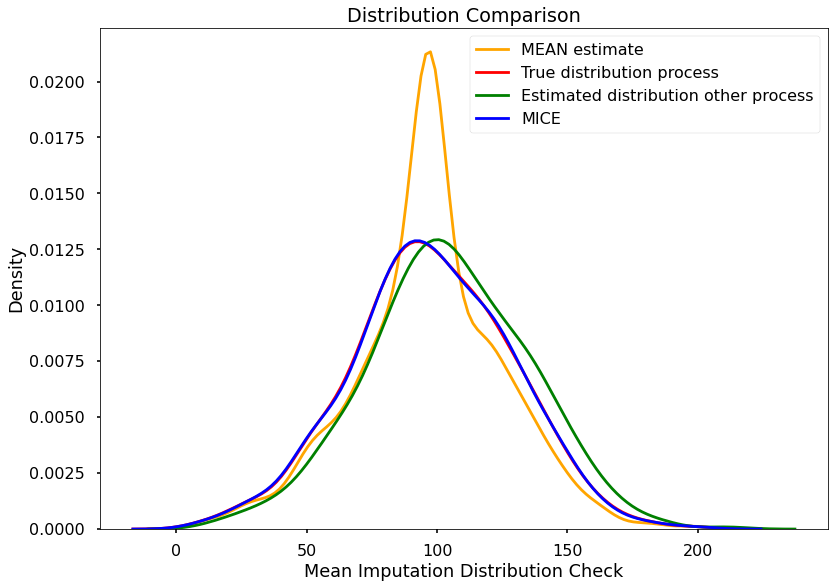

,MAE,RMSE
True-Value_vs_Process-Average,24.5821,30.889555
True-Value_vs_Average-estimation,4.1538,12.504235
True-Value_vs_MICE-estimation,0.7291,2.092654


In [ ]:
# 2.1 33% std bias 8
df = pd.read_csv("mock_1000_noise_8_std_0.33.csv")
nan_df = create_nan_df(df, dist_nan_columns = [0.20, 0.15, 0.08, 0],random_seed = 1)
imputed_df, metrics_df = replace_with_imputes_1 (nan_df, column_limit = 4)
plot_nan_df(imputed_df) 
metrics_df

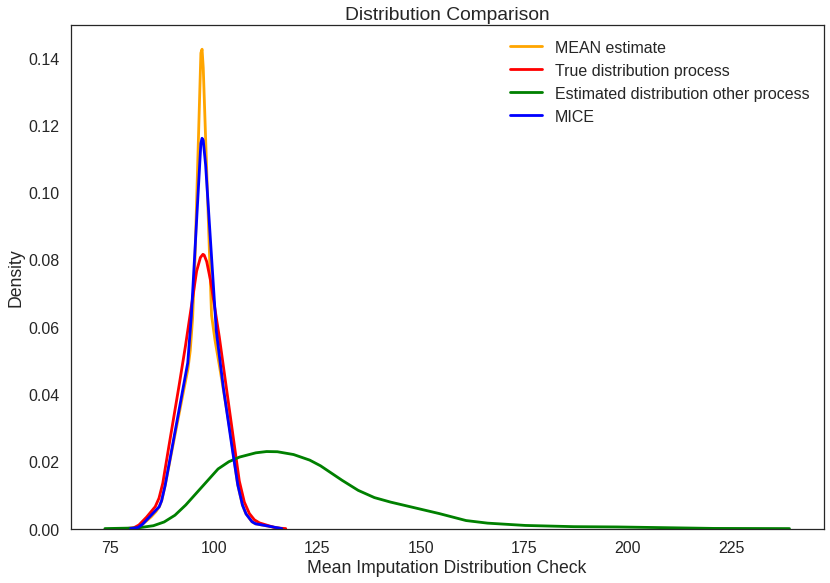

                                     MAE      RMSE
True-Value_vs_Process-Average     3.8663  4.857088
True-Value_vs_Average-estimation  0.7260  2.191415
True-Value_vs_MICE-estimation     0.7296  2.187327


In [ ]:
# 3.1 normal std bias 30                                                                         # Here it starts to fail. Finding: It doesnt make sense to use MICE based on processes that have no similarities. Low variance uses also makes no sense.
df = pd.read_csv("mock_1000_noise_30.csv")
nan_df = create_nan_df(df, dist_nan_columns = [0.20, 0.15, 0.08, 0],random_seed = 1)
imputed_df, metrics_df = replace_with_imputes_1 (nan_df, column_limit = 4) 
plot_nan_df(imputed_df)
print(metrics_df)

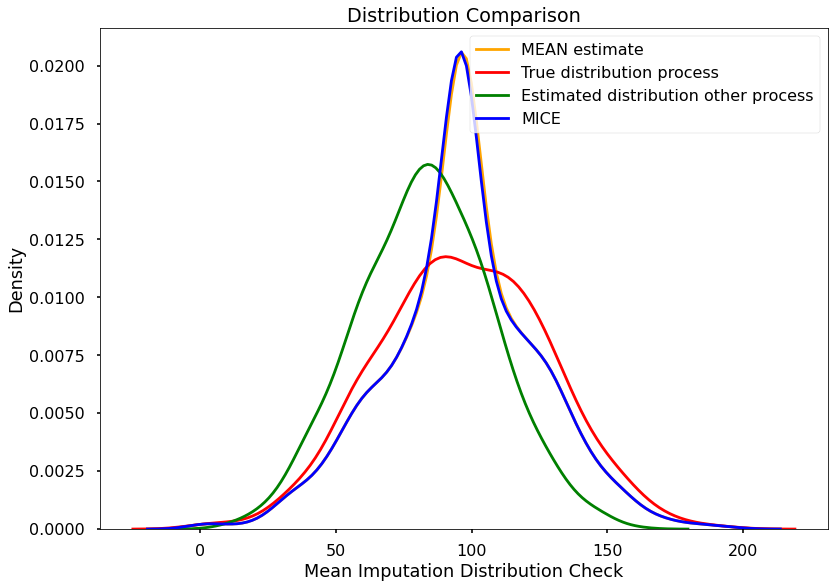

                                      MAE       RMSE
True-Value_vs_Process-Average     25.2641  31.196897
True-Value_vs_Average-estimation   4.6755  13.406484
True-Value_vs_MICE-estimation      4.6669  13.417910


In [ ]:
# UNSIMILAR  high 0.33 std 15 bias. 
df = pd.read_csv("mock_1000_15-0.33_Unsimilar.csv")
nan_df = create_nan_df(df, dist_nan_columns = [0.20, 0.15, 0.08, 0],random_seed = 1)
imputed_df, metrics_df = replace_with_imputes_1 (nan_df, column_limit = 4) 
plot_nan_df(imputed_df)
print(metrics_df)

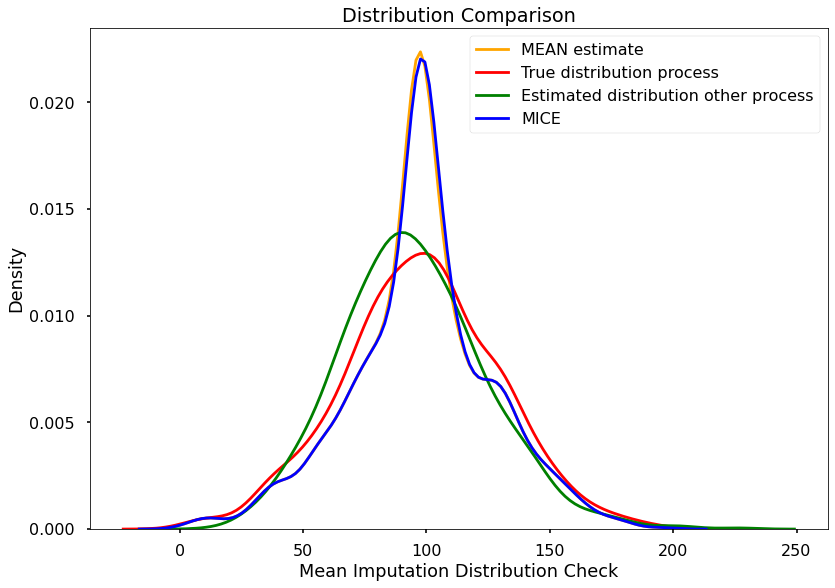

                                      MAE       RMSE
True-Value_vs_Process-Average     24.9669  31.705761
True-Value_vs_Average-estimation   4.2552  13.120785
True-Value_vs_MICE-estimation      4.2620  13.096717


In [ ]:
# UNSIMILAR  high 0.33 std 30 bias. 
df = pd.read_csv("mock_1000_30-0.33_Unsimilar.csv")
nan_df = create_nan_df(df, dist_nan_columns = [0.20, 0.15, 0.08, 0],random_seed = 1)
imputed_df, metrics_df = replace_with_imputes_1 (nan_df, column_limit = 4) 
plot_nan_df(imputed_df)
print(metrics_df)

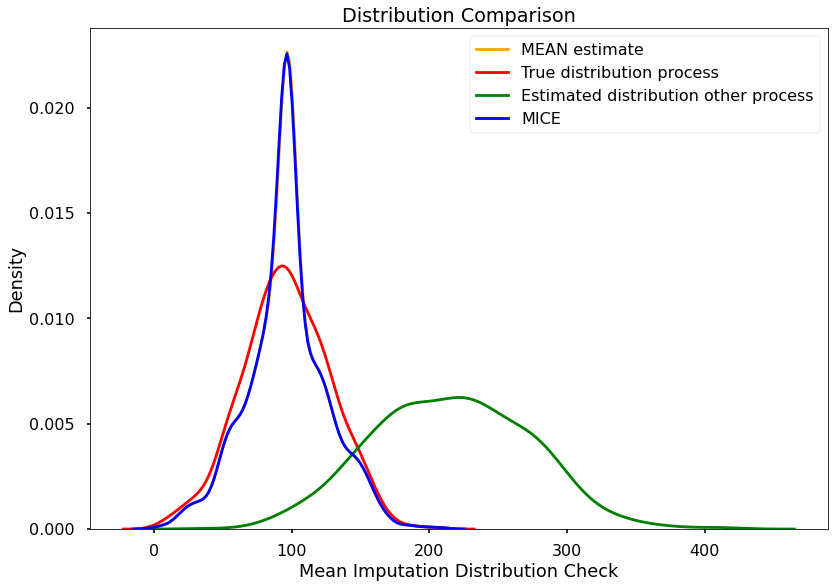

                                      MAE       RMSE
True-Value_vs_Process-Average     25.4112  31.966324
True-Value_vs_Average-estimation   4.8170  13.905894
True-Value_vs_MICE-estimation      4.8253  13.861201


In [ ]:
# UNSIMILAR  high 0.33 std 30 bias  + Ludicurous: 14.17, 2.85*(10**-1), 5.7*(10**-1) 
df = pd.read_csv("mock_1000_ludicurous_Unsimilar.csv")
nan_df = create_nan_df(df, dist_nan_columns = [0.20, 0.15, 0.08, 0],random_seed = 1)
imputed_df, metrics_df = replace_with_imputes_1 (nan_df, column_limit = 4) 
plot_nan_df(imputed_df)
print(metrics_df)

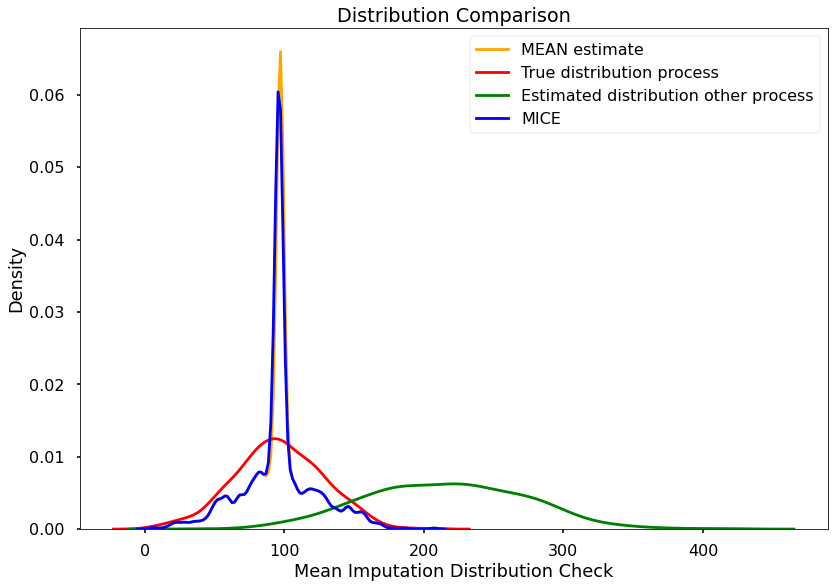

                                      MAE       RMSE
True-Value_vs_Process-Average     25.4112  31.966324
True-Value_vs_Average-estimation   9.4489  19.162943
True-Value_vs_MICE-estimation      9.4660  19.126505


In [ ]:
# UNSIMILAR  high 0.33 std 30 bias  + Ludicurous: 14.17, 2.85*(10**-1), 5.7*(10**-1)   . ++++ HIGH MISSING RATE ++++++
df = pd.read_csv("mock_1000_ludicurous_Unsimilar.csv")
nan_df = create_nan_df(df, dist_nan_columns = [0.40, 0.3, 0.2, 0],random_seed = 1)
imputed_df, metrics_df = replace_with_imputes_1 (nan_df, column_limit = 4) 
plot_nan_df(imputed_df)
print(metrics_df)

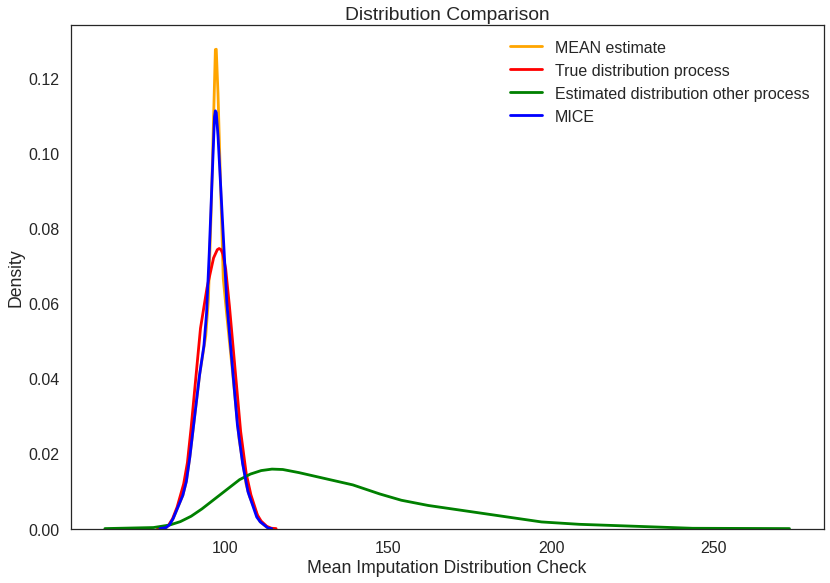

                                     MAE      RMSE
True-Value_vs_Process-Average     4.0000  4.940344
True-Value_vs_Average-estimation  0.6909  2.009726
True-Value_vs_MICE-estimation     0.6895  1.977701


In [ ]:
#3.2 normal std bias 45
df = pd.read_csv("mock_1000_noise_45.csv")
nan_df = create_nan_df(df, dist_nan_columns = [0.20, 0.15, 0.08, 0],random_seed = 1)
imputed_df, metrics_df = replace_with_imputes_1 (nan_df, column_limit = 4) 
plot_nan_df(imputed_df)
print(metrics_df)

In [ ]:
# 3.3 33% std bias 30 
df = pd.read_csv("mock_1000_noise_30_std_33.csv")
nan_df = create_nan_df(df, dist_nan_columns = [0.20, 0.15, 0.08, 0],random_seed = 1)
imputed_df, metrics_df = replace_with_imputes_1 (nan_df, column_limit = 4) 
metrics_df

plot_nan_df(imputed_df)
print(metrics_df)

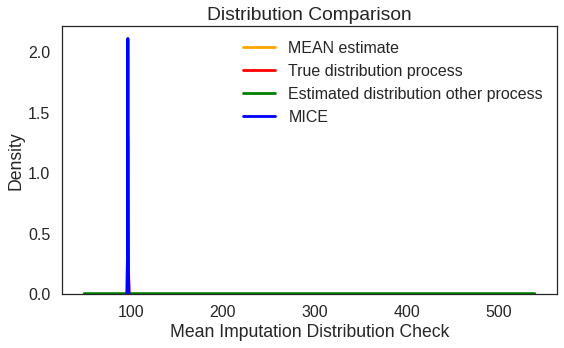

                                     MAE      RMSE
True-Value_vs_Process-Average     0.2342  0.288444
True-Value_vs_Average-estimation  0.0428  0.125698
True-Value_vs_MICE-estimation     0.0428  0.126095


In [ ]:
#3.4 66% std bias 55
df = pd.read_csv("mock_1000_ludicrous.csv")
nan_df = create_nan_df(df, dist_nan_columns = [0.20, 0.15, 0.08, 0],random_seed = 1)
imputed_df, metrics_df = replace_with_imputes_1 (nan_df, column_limit = 4) 
metrics_df

plot_nan_df(imputed_df, figs = (8,5))
print(metrics_df)

### Save Cases in Excel for plotting

In [ ]:
l = [metrics_df]
list_metrics_to_excel(l)

In [ ]:
nan_df.columns

Index(['CO2', 'CH4', 'N2O', 'Estimated_other_CO2e', 'True-Value_CO2e',
       'Process-Average_CO2e', 'Average_estimation_CO2e',
       'MICE_estimation_CO2e'],
      dtype='object')

# Generator


Equation was taken from GHG Compendium Chpt 3.3.2 (Shires et al. 2009)

$$ CO_2,e = \sum_i^{\text{# GHG Species}} (tonnes_i * \text{GWP}) $$

Sample from table 3-1 in Chpt. 3.3.1 (Shires et al. 2009)

| Gas           | GWP year > 2012| Petro-coke averages
| ------------- |:-------------:| :-------------:|
| $$CO_2$$      | 1             | 96.8        |
| $$CH_4$$      | 25            | 2.85E-03    |
| $$N_2O$$      | 298           | 5.70E-04    |


References:
- Shires, T. M., Loughran, C. J., Jones, S., & Hopkins, E. (2009). Compendium of greenhouse gas emissions methodologies for the oil and natural gas industry. Prepared by URS Corporation for the American Petroleum Institute (API). API, Washington DC.

In [ ]:
# hyper_parameters
noise = 30
p = 0.33  # percentage std

# ALTERNATIVE STATS , Crude OIL
# co2_mean = 14.7                                 # only change                      # Ludicurous mode if 14.17, 2.85*(10**-1), 5.7*(10**-1) 
# methane_mean = 2.85*(10**-1)
# nitrous_oxide_mean = 5.7*(10**-1)                                              


# calcultion: 
boundaries=[[co2_mean,co2_mean * p],[methane_mean, methane_mean * p],[ nitrous_oxide_mean, nitrous_oxide_mean * p]] #Optional. If not included set to None or remove from gen_regression_symbolic func.    old:  boundaries=[[15,5],[5,2],[0,0.01]]
x, y=gen_regression_symbolic(m='x1+25*x2+298*x3',n_samples=1000,noise=noise, 
                             noise_dist='normal', include_negatives=False, bounds=boundaries)

df=pd.DataFrame(x, columns=['CO2', 'CH4', 'N2O'])
df['Estimated_other_CO2e']=y.astype(float)

# Make true column and average column: 
for i in range(len(df)):
  df.loc[i,'True-Value_CO2e'] = df['CO2'][i] + 25* df['CH4'][i] + 298* df['N2O'][i]
df['Process-Average_CO2e'] = 96.8 + 25* methane_mean + 298* nitrous_oxide_mean

#df

In [ ]:
df['Estimated_other_CO2e'].head()

0    107.082125
1     89.947552
2    162.433023
3     90.507510
4    135.964925
Name: Estimated_other_CO2e, dtype: float64

In [ ]:
#  l = df['Estimated_other_CO2e'].values
df['Estimated_other_CO2e'] = l
df['Estimated_other_CO2e'].head()

0    205.626282
1    151.676381
2    222.489838
3    281.486619
4    149.106098
Name: Estimated_other_CO2e, dtype: float64

## Export data to CSV

In [ ]:
df.to_csv("../Unzipped files/mock_1000_ludicurous_Unsimilar.csv", index=False)

# Idea's : 
#### Perhaps do a MICE Speed test for various number of entrie: 1000; 10,000;  100,000; 1,000,000  and plot that. 

## Plot Data

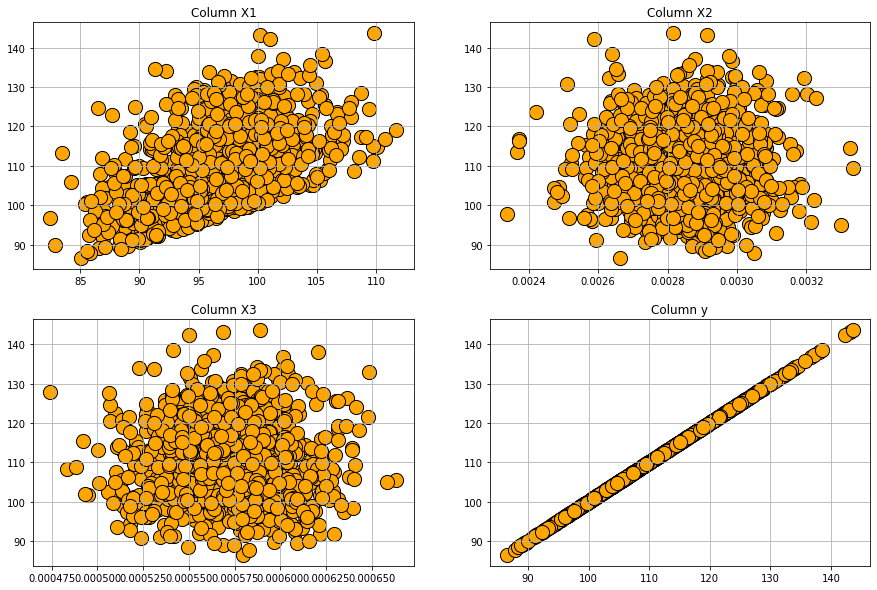

In [ ]:
plt.figure(figsize=(15,10))
for i in range(1, len(df.columns)+1):
    plt.subplot(math.ceil(len(df.columns)/2),math.ceil(len(df.columns)/2),i).title.set_text("Column "+str(df.columns[i-1]))
    plt.scatter(df[df.columns[i-1]],df['y'],s=200,c='orange',edgecolor='k')
    plt.grid(True)